# Minfilter 3D

In [10]:
%matplotlib inline
import pandas as pd
from os import listdir
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

pd.set_option('display.max_rows', 100)

path = 'csv'
prefix = 'minfilter_test_2048x2048'

columns = ['stat', 'rank', 'size', 'round', 'time_ms']
data = pd.DataFrame(columns=columns + ['method'])
for file in listdir(path):
    if not file.endswith('.csv') or file == 'stats.csv' or not file.startswith(prefix):
        continue
    if file.count('x') != 2:
        continue
    print(file)
    
    d = pd.read_csv(os.path.join(path, file), names=columns)
    d['method'] = file.replace('.csv', '').split('_')[-1]
    d['image_size'] = int(file.replace('.csv', '').split('_')[-2].split('x')[-1])
    
    data = pd.concat([data, d])
data.reset_index()

for t in ['rank', 'size', 'round', 'time_ms']:
    data[t] = data[t].astype('int')

# skip first run
data = data[(data['round'] == 0)] # | (data['stat'].isin(['read', 'write']))]
data['image_size'].unique()

def fix_labels(ax):
    for label in ax.legend().get_texts():
        n = int(float(label.get_text()))
        label.set_text(f"2048x2048x{n}")

minfilter_test_2048x2048x1000_clij.csv
minfilter_test_2048x2048x1000_default.csv
minfilter_test_2048x2048x1000_mpi.csv
minfilter_test_2048x2048x1000_nativempi.csv
minfilter_test_2048x2048x100_clij.csv
minfilter_test_2048x2048x100_default.csv
minfilter_test_2048x2048x100_mpi.csv
minfilter_test_2048x2048x100_nativempi.csv
minfilter_test_2048x2048x10_clij.csv
minfilter_test_2048x2048x10_default.csv
minfilter_test_2048x2048x10_mpi.csv
minfilter_test_2048x2048x10_nativempi.csv
minfilter_test_2048x2048x1500_clij.csv
minfilter_test_2048x2048x1500_default.csv
minfilter_test_2048x2048x500_clij.csv
minfilter_test_2048x2048x500_default.csv
minfilter_test_2048x2048x500_mpi.csv
minfilter_test_2048x2048x500_nativempi.csv
minfilter_test_2048x2048x50_clij.csv
minfilter_test_2048x2048x50_default.csv
minfilter_test_2048x2048x50_mpi.csv
minfilter_test_2048x2048x50_nativempi.csv


In [4]:
def by_imagesize(method, stat='total_op'):
    series = {}
    for image_size in sorted(data['image_size'].unique()):
        ds = data[(data['stat'] == stat) & (data['method'] == method) & (data['image_size'] == image_size)].pivot_table(index=['size', 'round'], columns='rank', values='time_ms')
        time = defaultdict(list)
        for idx, times in ds.iterrows():
            size, round = idx
            time[size].append(max(times))

        averaged = {k: sum(v)/len(v) for k, v in time.items()} 
        series[image_size] = pd.Series(averaged, dtype=np.float64)
    
    df = pd.DataFrame(series).dropna(axis=1,how='all')
    df.index.name = 'size'
    return df
display('default')
display(by_imagesize('default'))
display('mpi')
display(by_imagesize('mpi'))
display('nativempi')
display(by_imagesize('nativempi'))
display('mpisingle')
display(by_imagesize('mpisingle'))
display('clij')
display(by_imagesize('clij'))

'default'

,10.0,50.0,100.0,500.0
size,,,,
1,11208.0,53148.0,109524.0,561052.0


'mpi'

,10.0,50.0,100.0,500.0,1000.0
size,,,,,
1,10701.0,51905.0,101338.0,512808.0,980659.0
2,5750.0,26656.0,53077.0,260495.0,534629.0
4,3311.0,13885.0,27331.0,134168.0,266242.0
6,2690.0,11742.0,18226.0,92687.0,197591.0
8,2759.0,7498.0,14337.0,68455.0,140270.0


'nativempi'

,10.0,50.0,100.0,500.0,1000.0
size,,,,,
1,1195.0,5129.0,10145.0,49741.0,99194.0
2,990.0,2906.0,5536.0,26440.0,52906.0
4,904.0,1937.0,3335.0,15127.0,29746.0
6,883.0,1707.0,2699.0,12386.0,22566.0
8,1069.0,1696.0,17265.0,9543.0,18443.0


'mpisingle'

""
size


'clij'

,10.0,50.0,100.0,500.0
size,,,,
1,4713.0,6136.0,8200.0,28264.0


In [5]:
by_imagesize('nativempi')#, stat='copyToNative')
by_imagesize('mpi', stat='gather')

,10.0,50.0,100.0,500.0,1000.0
size,,,,,
1,27.0,82.0,156.0,771.0,1478.0
2,51.0,130.0,221.0,1380.0,2159.0
4,72.0,155.0,257.0,1384.0,2088.0
6,101.0,1013.0,378.0,1909.0,3411.0
8,147.0,229.0,373.0,1778.0,3254.0


## Computation time for minimal filter on 3-neighbourhood

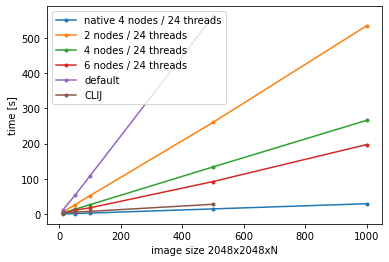

In [6]:
plt.plot(by_imagesize('nativempi').loc[4]/1000, marker='.', label='native 4 nodes / 24 threads')
plt.plot(by_imagesize('mpi').loc[2]/1000, marker='.', label='2 nodes / 24 threads')
plt.plot(by_imagesize('mpi').loc[4]/1000, marker='.', label='4 nodes / 24 threads')
plt.plot(by_imagesize('mpi').loc[6]/1000, marker='.', label='6 nodes / 24 threads')
plt.plot(by_imagesize('default').loc[1]/1000, marker='.', label='default')
plt.plot(by_imagesize('clij').loc[1]/1000, marker='.', label='CLIJ')
plt.xlabel('image size 2048x2048xN')
plt.ylabel('time [s]')
plt.legend()
plt.savefig('figures/minfilter3d_comparison.pdf')

In [7]:
display(by_imagesize('mpi', stat='gather'))
display(by_imagesize('mpi', stat='cz.it4i.scijava.mpi.ops.parallel.Parallel'))
#display(by_imagesize('mpi', stat='barrier'))
display(by_imagesize('mpi', stat='total_op'))

,10.0,50.0,100.0,500.0,1000.0
size,,,,,
1,27.0,82.0,156.0,771.0,1478.0
2,51.0,130.0,221.0,1380.0,2159.0
4,72.0,155.0,257.0,1384.0,2088.0
6,101.0,1013.0,378.0,1909.0,3411.0
8,147.0,229.0,373.0,1778.0,3254.0


,10.0,50.0,100.0,500.0,1000.0
size,,,,,
1,10486.0,51669.0,101092.0,512115.0,979568.0
2,5473.0,26414.0,52725.0,259761.0,533520.0
4,2979.0,13521.0,26908.0,133409.0,265085.0
6,2291.0,10726.0,17855.0,91911.0,196457.0
8,2300.0,7020.0,13840.0,67719.0,139144.0


,10.0,50.0,100.0,500.0,1000.0
size,,,,,
1,10701.0,51905.0,101338.0,512808.0,980659.0
2,5750.0,26656.0,53077.0,260495.0,534629.0
4,3311.0,13885.0,27331.0,134168.0,266242.0
6,2690.0,11742.0,18226.0,92687.0,197591.0
8,2759.0,7498.0,14337.0,68455.0,140270.0


## native mpi computation time

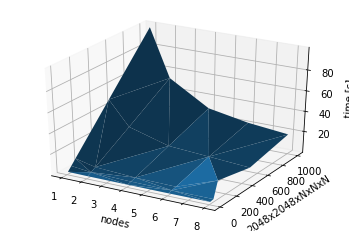

In [8]:
d = pd.DataFrame(by_imagesize('nativempi').unstack().reset_index())
d.rename(columns={'level_0':'image_size', 0: 'time_ms'}, inplace=True)

fig = plt.figure()
ax = fig.gca(projection='3d') #, title='Convolution time of image size on number of nodes/1thread')
ax.plot_trisurf(d['size'], d['image_size'], d['time_ms'] / 1000)
ax.set_xlabel('nodes')
ax.set_ylabel('2048x2048xNxNxN')
ax.set_zlabel('time [s]')
plt.savefig('figures/minfilter3d_mpisingle_3d.pdf')
plt.show()

,10.0,50.0,100.0,500.0,1000.0,ideal
size,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1
2,1.861043,1.947216,1.909264,1.968591,1.834279,2
4,3.231954,3.738207,3.707804,3.822133,3.683337,4
6,3.978067,4.420456,5.560079,5.532685,4.963075,6
8,3.878579,6.922513,7.068285,7.491169,6.991224,8


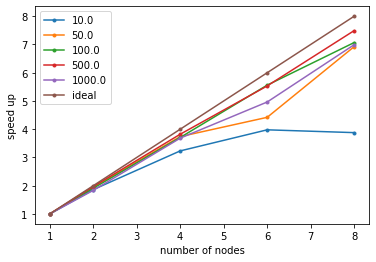

In [12]:
ds = by_imagesize('mpi')

speedup = ds.iloc[0] / ds
speedup['ideal'] = list(ds.index)
display(speedup)
ax = speedup.plot(marker='.') #, title='convolution speedup for single thread')
ax.set_ylabel('speed up')
ax.set_xlabel('number of nodes')
plt.savefig('figures/minfilter3d_mpisingle_speedup.pdf')